<a href="https://colab.research.google.com/github/andrei-micuda/TheWardrobeVue/blob/master/ClothesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copy the DeepFashion dataset from Google Drive to the local Colab file system.

In [ ]:
#@title

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar  1 11:25:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |  14544MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Dataset

In [1]:
!unzip -qq /content/drive/MyDrive/DeepFashion/img.zip -d /content/raw_dataset

In [2]:
!cp /content/drive/MyDrive/DeepFashion/Anno/list_category_cloth.txt /content/raw_dataset/list_category_cloth.txt
!cp /content/drive/MyDrive/DeepFashion/Anno/list_category_img.txt /content/raw_dataset/list_category_img.txt
!cp /content/drive/MyDrive/DeepFashion/Anno/list_eval_partition.txt /content/raw_dataset/list_eval_partition.txt

In [3]:
# !rm -r dataset

Create the necessary file structure in order to use `tf.keras.utils.image_dataset_from_directory`.

In [4]:
import os, shutil, pathlib

new_base_dir = pathlib.Path("/content/dataset")
original_dir = pathlib.Path("/content/raw_dataset")

In [5]:
def read_categories():
    dir = original_dir / "list_category_cloth.txt";
    with open(dir) as fin:
        fin.readline();
        fin.readline();
        return [line.strip().split()[0] for line in fin.readlines()];
    
def create_folder_structure(subset_name, categories):
    for cat in categories:
        dir = new_base_dir / subset_name / cat
        os.makedirs(dir)
        
def populate_folders():
    with open(original_dir / "list_category_img.txt") as img_cats, open(original_dir / f"list_eval_partition.txt") as img_subsets:
        img_cats.readline();
        img_subsets.readline();
        img_cats.readline();
        img_subsets.readline();
        
        for i, (img_cat, img_subset) in enumerate(zip(img_cats.readlines(), img_subsets.readlines())):
            img_path, img_cat = img_cat.strip().split()
            _, img_subset = img_subset.strip().split()
            cat_name = categories[int(img_cat) - 1]
            
            save_path = new_base_dir / img_subset / cat_name
            original_path = original_dir / img_path
            shutil.copyfile(src=original_path, dst=save_path / f"{img_cat}_image_{i}.jpg")
            if(i % 10000 == 0):
                print(f"Finished copying {i} images")
    
categories = read_categories();
create_folder_structure("train", categories);
create_folder_structure("val", categories);
create_folder_structure("test", categories);

populate_folders();

Finished copying 0 images
Finished copying 10000 images
Finished copying 20000 images
Finished copying 30000 images
Finished copying 40000 images
Finished copying 50000 images
Finished copying 60000 images
Finished copying 70000 images
Finished copying 80000 images
Finished copying 90000 images
Finished copying 100000 images
Finished copying 110000 images
Finished copying 120000 images
Finished copying 130000 images
Finished copying 140000 images
Finished copying 150000 images
Finished copying 160000 images
Finished copying 170000 images
Finished copying 180000 images
Finished copying 190000 images
Finished copying 200000 images
Finished copying 210000 images
Finished copying 220000 images
Finished copying 230000 images
Finished copying 240000 images
Finished copying 250000 images
Finished copying 260000 images
Finished copying 270000 images
Finished copying 280000 images


Load the images into datasets.

In [6]:
# from tensorflow.keras.utils import image_dataset_from_directory

# train_dataset = image_dataset_from_directory(
#     new_base_dir / "train",
#     batch_size=64,
#     image_size=(229, 229),
#     label_mode='int')

# test_dataset = image_dataset_from_directory(
#     new_base_dir / "test",
#     batch_size=64,
#     image_size=(229, 229),
#     label_mode='int')

# val_dataset = image_dataset_from_directory(
#     new_base_dir / "val",
#     batch_size=64,
#     image_size=(229, 229),
#     label_mode='int')

# DATASET_NUM_TRAIN_EXAMPLES = 209222

# Explore the dataset

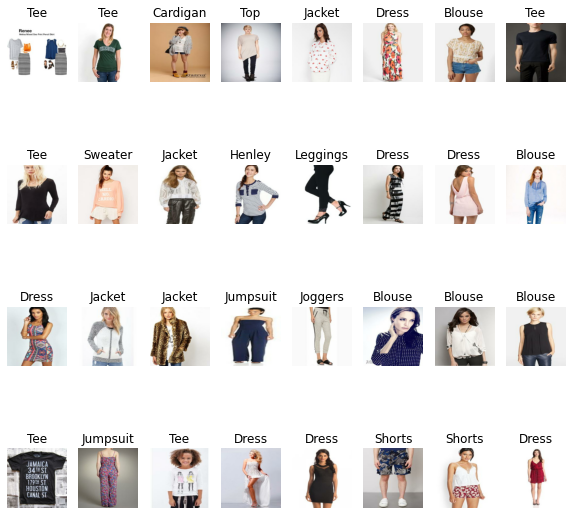

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
class_names = test_dataset.class_names
for images, labels in test_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# VGG16

We are going to leverage the VGG16 base convolution network for feature extraction.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))
conv_base.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
# x = layers.Dense(4096, activation="relu")(x)
# x = layers.Dense(4096, activation="relu")(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

# test_model = keras.models.load_model(
#     "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Epoch 1/10


ValueError: ignored

# ResNet50

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics

conv_base = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(229, 229, 3))
conv_base.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.1)
    ]
)

inputs = keras.Input(shape=(229, 229, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
outputs = layers.Dense(50, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy", metrics.SparseTopKCategoricalAccuracy(k=5)])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

Train the added layers for 1 epoch, then unfreeze the whole model and train for 2 more epochs.

In [ ]:
model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset)

conv_base.trainable = True

model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/5
3270/3270 [==============================] - 559s 170ms/step - loss: 24.3191 - accuracy: 0.5656 - sparse_top_k_categorical_accuracy: 0.9163 - val_loss: 32.9684 - val_accuracy: 0.5348 - val_sparse_top_k_categorical_accuracy: 0.8989
Epoch 2/5
3270/3270 [==============================] - 559s 171ms/step - loss: 23.6032 - accuracy: 0.5814 - sparse_top_k_categorical_accuracy: 0.9276 - val_loss: 35.3455 - val_accuracy: 0.5056 - val_sparse_top_k_categorical_accuracy: 0.9002
Epoch 3/5
3270/3270 [==============================] - 559s 171ms/step - loss: 23.1559 - accuracy: 0.5941 - sparse_top_k_categorical_accuracy: 0.9357 - val_loss: 38.8775 - val_accuracy: 0.5357 - val_sparse_top_k_categorical_accuracy: 0.9087
Epoch 4/5
3270/3270 [==============================] - 560s 171ms/step - loss: 22.7802 - accuracy: 0.6059 - sparse_top_k_categorical_accuracy: 0.9412 - val_loss: 39.2776 - val_accuracy: 0.5508 - val_sparse_top_k_categorical_accuracy: 0.9246
Epoch 5/5
3270/3270 [===============

In [ ]:
from tensorflow import keras

test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc, top_5_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test top 5 accuracy: {top_5_acc:.3f}")


625/625 [==============================] - 91s 141ms/step - loss: 30.2070 - accuracy: 0.5085 - sparse_top_k_categorical_accuracy: 0.8806
Test accuracy: 0.509
Test top 5 accuracy: 0.881


# BiT

In [7]:
import tensorflow as tf
import tensorflow_hub as hub

In [8]:
#@title

def read_categories():
    dir = original_dir / "list_category_cloth.txt";
    with open(dir) as fin:
        fin.readline();
        fin.readline();
        return [line.strip().split()[0] for line in fin.readlines()];

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.where(parts[4] == categories)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  features = {'image': img, 'label': label}
  return features

def generate_dataset(subset_name):
  list_ds = tf.data.Dataset.list_files(f'/content/dataset/{subset_name}/*/*')
  ds = list_ds.map(process_path)
  return ds

categories = read_categories()
ds_train = generate_dataset("train")
DATASET_NUM_TRAIN_EXAMPLES = len(ds_train)
ds_test = generate_dataset("test")
ds_val = generate_dataset("val")

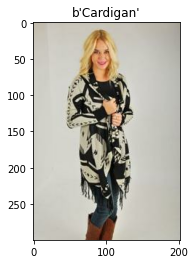

In [38]:
#@title
import matplotlib.pyplot as plt

for features in ds_train.take(1):
  image = features['image']
  label = features['label'].numpy()
  plt.imshow(image)
  plt.title(label)
  plt.show()
  # image = preprocess_image(image)

In [9]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

# Load model into KerasLayer
model_url = "https://tfhub.dev/google/experts/bit/r50x1/in21k/clothing/1"
module = hub.KerasLayer(model_url)

model = MyBiTModel(num_classes=50, module=module)

In [10]:
IMAGE_SIZE = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "20k-500k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [18]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 128
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

def cast_to_tuple(features):
  return (features['image'], features['label'])
  
def preprocess_train(features):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  features['image'] = tf.image.random_flip_left_right(features['image'])
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

def preprocess_val(features):
  features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0
  return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_val = (ds_val.map(preprocess_val, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [19]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_val  # here we are only using 
                                   # this data to evaluate our performance
)

# history = model.fit(
#     pipeline_train,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
#     validation_data=pipeline_val  # here we are only using 
#                                   # this data to evaluate our performance
# )

Epoch 1/16000
